In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv('/content/drive/MyDrive/DGdataset/Sample Time Series/hourly/classification_attempt_1.csv' , index_col = 0)
df.head()

,Sample Index,Mean,Variance,Skewness,Kurtosis,Trend Mean,Seasonal Mean,Residual Mean,Best Model
0,0,526.697948,1580.179445,1.752512,6.446002,527.833336,0.040769,-1.176157,ETS
1,1,531.107493,2087.632395,1.920251,5.939047,529.340228,0.987871,0.779393,ARIMA
2,2,534.096876,2097.448578,1.674601,4.921075,532.137554,1.271351,0.687971,ARIMA
3,3,535.898369,2044.734436,1.556184,4.614765,535.829758,0.482107,-0.413497,ARIMA
4,4,536.418059,1960.844482,1.541476,4.744824,538.980866,0.110815,-2.673621,ARIMA


In [8]:
df.drop('Sample Index' , axis = 1 , inplace = True)

<Axes: >

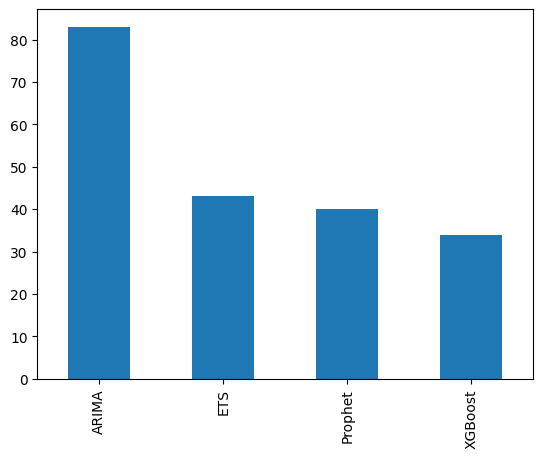

In [9]:
df["Best Model"].value_counts().plot(kind="bar")

In [10]:
method_to_label = {'ARIMA': 0, 'XGBoost': 1, 'Prophet': 2, 'ETS': 3}
df['model'] = df['Best Model'].map(method_to_label)

<ipython-input-11-b207939247ec>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


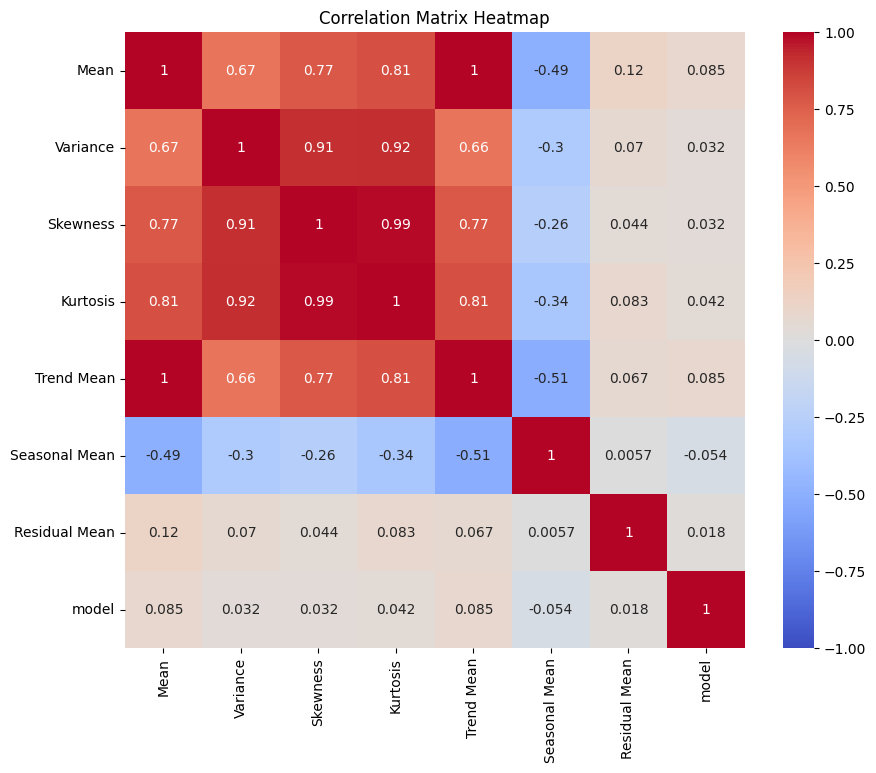

In [11]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix Heatmap")
plt.show()

<ipython-input-14-3fce574c2dc1>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


,Mean,Variance,Seasonal Mean,Residual Mean,Best Model,model
0,526.697948,1580.179445,0.040769,-1.176157,ETS,3
1,531.107493,2087.632395,0.987871,0.779393,ARIMA,0
2,534.096876,2097.448578,1.271351,0.687971,ARIMA,0
3,535.898369,2044.734436,0.482107,-0.413497,ARIMA,0
4,536.418059,1960.844482,0.110815,-2.673621,ARIMA,0
...,...,...,...,...,...,...
195,565.028927,3766.096312,0.001899,0.144857,ARIMA,0
196,565.647273,4354.279059,0.010738,0.297428,Prophet,2
197,565.801959,4341.653698,0.056315,-0.195761,ETS,3
198,566.042007,4345.653029,0.025917,-0.316412,ARIMA,0


In [ ]:
corr_matrix

,Mean,Variance,Skewness,Kurtosis,Trend Mean,Seasonal Mean,Residual Mean,model
Mean,1.000000,-0.838687,-0.184794,0.820731,0.999996,-0.705709,0.230139,0.275719
Variance,-0.838687,1.000000,-0.271323,-0.948886,-0.838728,0.658803,-0.234572,-0.293234
Skewness,-0.184794,-0.271323,1.000000,0.095276,-0.184534,-0.023602,0.002885,-0.088828
Kurtosis,0.820731,-0.948886,0.095276,1.000000,0.820633,-0.644850,0.273426,0.358911
Trend Mean,0.999996,-0.838728,-0.184534,0.820633,1.000000,-0.706226,0.227811,0.276145
Seasonal Mean,-0.705709,0.658803,-0.023602,-0.644850,-0.706226,1.000000,-0.414398,-0.262995
Residual Mean,0.230139,-0.234572,0.002885,0.273426,0.227811,-0.414398,1.000000,-0.015290
model,0.275719,-0.293234,-0.088828,0.358911,0.276145,-0.262995,-0.015290,1.000000


In [ ]:
df.head()

,Mean,Variance,Kurtosis,Trend Mean,Seasonal Mean,Residual Mean,Best Model,model
0,1.170354e+06,4.007895e+10,3.071583,1.170865e+06,-3.686601e+03,3176.103442,Prophet,2
1,1.173173e+06,4.021102e+10,2.854922,1.173717e+06,-4.948876e+02,-48.892901,ARIMA,0
2,1.165945e+06,4.167459e+10,2.653146,1.170509e+06,-2.861151e+03,-1702.486047,ETS,3
3,1.161884e+06,4.173290e+10,2.661183,1.162507e+06,1.455192e-11,-623.829597,XGBoost,1
4,1.154895e+06,4.314659e+10,2.477578,1.153841e+06,-1.812498e+03,2866.969396,ARIMA,0


In [ ]:
df.tail()

,Mean,Variance,Kurtosis,Trend Mean,Seasonal Mean,Residual Mean,Best Model,model
195,439600.023316,1.932588e+11,-0.340374,439964.297210,-1.362506e+01,-350.648835,ARIMA,0
196,439580.920993,1.924795e+11,-0.329830,439345.646991,-2.278368e+01,258.057679,ARIMA,0
197,438877.345837,1.918428e+11,-0.316556,439316.425772,-1.588179e+01,-423.198141,XGBoost,1
198,438961.104406,1.910553e+11,-0.306385,439383.515559,-2.022823e+00,-420.388329,XGBoost,1
199,437816.498893,1.906591e+11,-0.294135,438657.270709,-1.049417e-13,-840.771815,ETS,3


In [ ]:
df.drop('Skewness' , axis = 1 , inplace = True)

In [ ]:
# df_encoded = pd.get_dummies(df, columns=['model'], prefix='method')
# df_encoded.head()

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

X = df.drop(['model', 'Best Model'], axis=1)
y = df['model']

print("Class distribution before undersampling:")
print(Counter(y))

# Initialize the RandomUnderSampler with desired sampling strategy
undersampler = RandomUnderSampler(sampling_strategy={0: 25 , 1:25}, random_state=40)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

print("Class distribution after undersampling:")
print(Counter(y_resampled))

# Initialize the RandomOverSampler with desired sampling strategy
oversampler = RandomOverSampler(sampling_strategy={3: 25 , 2 : 25}, random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_resampled, y_resampled)

print("Class distribution after upsampling:")
print(Counter(y_resampled))

Class distribution before undersampling:
Counter({0: 140, 1: 35, 3: 14, 2: 11})
Class distribution after undersampling:
Counter({0: 25, 1: 25, 3: 14, 2: 11})
Class distribution after upsampling:
Counter({0: 25, 1: 25, 2: 25, 3: 25})


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline

rf_classifier = RandomForestClassifier(class_weight='balanced')

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
}
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)


pipeline = Pipeline([
    ('clf', grid_search)
])

shuffled_df = df.sample(frac=1, random_state=42)

X = X_resampled
y = y_resampled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

pipeline.fit(X_train, y_train)
best_rf_model = pipeline.named_steps['clf'].best_estimator_
best_params = pipeline.named_steps['clf'].best_params_

with open('random_forest_model_grid_cv_1.pkl', 'wb') as model_file:
    pickle.dump(best_rf_model, model_file)

y_pred = best_rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Accuracy: 0.65
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.60      0.50      0.55         6
           2       0.62      1.00      0.77         5
           3       0.50      0.33      0.40         3

    accuracy                           0.65        20
   macro avg       0.63      0.62      0.61        20
weighted avg       0.65      0.65      0.63        20



In [ ]:
y_pred , y_test

(array([3, 0, 1, 2, 0, 0, 1, 0, 1, 1, 1, 1, 2]),
 53    3
 60    3
 0     0
 45    2
 5     0
 61    3
 16    0
 12    0
 64    3
 30    1
 33    1
 9     0
 41    2
 Name: model, dtype: int64)

In [ ]:
path_map = {
    "daily" : "/content/drive/MyDrive/DGdataset/Sample Time Series/daily/classification_attempt_6.csv" ,
    # "hourly" : "/content/drive/MyDrive/DGdataset/Sample Time Series/hourly/classification_attempt_1.csv" ,
    # "monthly" : "/content/drive/MyDrive/DGdataset/Sample Time Series/monthly/classification_attempt_1.csv" ,
    # "weekly" : "/content/drive/MyDrive/DGdataset/Sample Time Series/weekly/classification_attempt_1.csv" ,
}

attempt = 4

for format,path in path_map.items():
  df = pd.read_csv(path , index_col = 0)
  df.drop(columns = ['Sample Index' , 'Skewness'] , axis = 1 , inplace = True)

  method_to_label = {'ARIMA': 0, 'XGBoost': 1, 'Prophet': 2, 'ETS': 3}
  df['model'] = df['Best Model'].map(method_to_label)

  X = df.drop(['model', 'Best Model'], axis=1)
  y = df['model']

  print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
  print("Format" , format)
  print("Class distribution before undersampling:")
  print(Counter(y))

  # Initialize the RandomUnderSampler with desired sampling strategy
  undersampler = RandomUnderSampler(sampling_strategy={0: 25 , 1:25}, random_state=40)
  X_resampled, y_resampled = undersampler.fit_resample(X, y)

  print("Class distribution after undersampling:")
  print(Counter(y_resampled))

  # Initialize the RandomOverSampler with desired sampling strategy
  oversampler = RandomOverSampler(sampling_strategy={3: 25 , 2 : 25}, random_state=42)
  X_resampled, y_resampled = oversampler.fit_resample(X_resampled, y_resampled)

  print("Class distribution after upsampling:")
  print(Counter(y_resampled))


  rf_classifier = RandomForestClassifier(class_weight='balanced')

  param_grid = {
      'n_estimators': [100, 200, 300],
      'max_depth': [10, 20, 30],
  }
  grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)


  pipeline = Pipeline([
      ('clf', grid_search)
  ])

  X = X_resampled
  y = y_resampled
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

  pipeline.fit(X_train, y_train)
  best_rf_model = pipeline.named_steps['clf'].best_estimator_
  best_params = pipeline.named_steps['clf'].best_params_

  y_pred = best_rf_model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy:", accuracy)

  report = classification_report(y_test, y_pred)
  print("Classification Report:\n", report)

  store_path = '/content/drive/MyDrive/DGdataset/Sample Time Series/model/rf_'+format+str(attempt)+".pkl"

  with open(store_path, 'wb') as model_file:
      pickle.dump(best_rf_model, model_file)

  print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
  print()

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Format daily
Class distribution before undersampling:
Counter({0: 140, 1: 35, 3: 14, 2: 11})
Class distribution after undersampling:
Counter({0: 25, 1: 25, 3: 14, 2: 11})
Class distribution after upsampling:
Counter({0: 25, 1: 25, 2: 25, 3: 25})
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Accuracy: 0.6
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.67      0.67         6
           1       0.50      0.33      0.40         6
           2       0.62      1.00      0.77         5
           3       0.50      0.33      0.40         3

    accuracy                           0.60        20
   macro avg       0.57      0.58      0.56        20
weighted avg       0.58      0.60      0.57        20

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



In [1]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
path_map = {
    "daily" : "/content/drive/MyDrive/DGdataset/Sample Time Series/daily/classification_attempt_6.csv" ,
    "hourly" : "/content/drive/MyDrive/DGdataset/Sample Time Series/hourly/classification_attempt_1.csv" ,
    "monthly" : "/content/drive/MyDrive/DGdataset/Sample Time Series/monthly/classification_attempt_1.csv" ,
    "weekly" : "/content/drive/MyDrive/DGdataset/Sample Time Series/weekly/classification_attempt_1.csv" ,
}

attempt = 7

for format,path in path_map.items():
  df = pd.read_csv(path , index_col = 0)
  df.drop(columns = ['Sample Index' , 'Skewness'] , axis = 1 , inplace = True)

  method_to_label = {'ARIMA': 0, 'XGBoost': 1, 'Prophet': 2, 'ETS': 3}
  df['model'] = df['Best Model'].map(method_to_label)

  if format == "daily":
    under_sample = {
        0: 25 ,
        1:25
    }
    over_sample = {
        3: 25 ,
        2 : 25
    }
  elif format == "hourly":

    corr_matrix = df.corr()
    high_corr_features = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > 0.7:
                colname = corr_matrix.columns[i]
                high_corr_features.add(colname)
    df.drop(columns=high_corr_features , inplace = True)

    under_sample = {
        0 : 30,
        3 : 30,
        2 : 30,
        1 : 30

    }
    over_sample = {

    }
  elif format == "monthly":
    under_sample = {
        0: 25 ,
        1: 25
    }
    over_sample ={
        3 : 25 ,
        2 : 25
    }
  elif format == "weekly":
    df.drop(columns = ['Seasonal Mean' , 'Residual Mean'] , axis = 1 , inplace = True)
    under_sample = {
        1: 25
    }
    over_sample ={
        3 : 25 ,
        2 : 25,
        0 : 25
    }

  X = df.drop(['model', 'Best Model'], axis=1)
  y = df['model']

  print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
  print("Format" , format , df.columns)
  print("Class distribution before undersampling:")
  print(Counter(y))

  # Initialize the RandomUnderSampler with desired sampling strategy
  undersampler = RandomUnderSampler(sampling_strategy=under_sample, random_state=40)
  X_resampled, y_resampled = undersampler.fit_resample(X, y)

  print("Class distribution after undersampling:")
  print(Counter(y_resampled))

  # Initialize the RandomOverSampler with desired sampling strategy
  oversampler = RandomOverSampler(sampling_strategy=over_sample, random_state=42)
  X_resampled, y_resampled = oversampler.fit_resample(X_resampled, y_resampled)

  print("Class distribution after upsampling:")
  print(Counter(y_resampled))
  print()



  X = X_resampled
  y = y_resampled
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

  classifiers = {
    'RandomForest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [100, 200, 300, 500],
            'max_depth': [10, 20, 30],
            # 'min_samples_split': [2, 5, 10],
            # 'min_samples_leaf': [1, 2, 4],
        }
    }
  }

  results = {}
  for classifier_name, classifier_info in classifiers.items():
      clf = classifier_info['model']
      param_grid = classifier_info['params']

      grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy')
      grid_search.fit(X_train, y_train)

      best_params = grid_search.best_params_
      best_model = grid_search.best_estimator_
      y_pred = best_model.predict(X_test)

      accuracy = accuracy_score(y_test, y_pred)


      store_path = '/content/drive/MyDrive/DGdataset/Sample Time Series/model/'+classifier_name+str(accuracy)+format+str(attempt)+".pkl"
      with open(store_path, 'wb') as model_file:
          pickle.dump(best_model, model_file)


      classification_rep = classification_report(y_test, y_pred, output_dict=True)
      results[classifier_name] = {
          'best_params': best_params,
          'classification_report': classification_rep
      }

  # Print the results for each classifier
  for classifier_name, result in results.items():
      print(f"Classifier: {classifier_name}")
      print(f"Best Parameters: {result['best_params']}")
      print("Classification Report:")
      print(pd.DataFrame.from_dict(result['classification_report']).T)
      print()



  print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
  print()

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Format daily Index(['Mean', 'Variance', 'Kurtosis', 'Trend Mean', 'Seasonal Mean',
       'Residual Mean', 'Best Model', 'model'],
      dtype='object')
Class distribution before undersampling:
Counter({0: 140, 1: 35, 3: 14, 2: 11})
Class distribution after undersampling:
Counter({0: 25, 1: 25, 3: 14, 2: 11})
Class distribution after upsampling:
Counter({0: 25, 1: 25, 2: 25, 3: 25})

Classifier: RandomForest
Best Parameters: {'max_depth': 10, 'n_estimators': 200}
Classification Report:
              precision    recall  f1-score  support
0              0.666667  0.666667  0.666667      6.0
1              0.500000  0.333333  0.400000      6.0
2              0.625000  1.000000  0.769231      5.0
3              0.500000  0.333333  0.400000      3.0
accuracy       0.600000  0.600000  0.600000      0.6
macro avg      0.572917  0.583333  0.558974     20.0
weighted avg   0.581250  0.600000  0.572308     20.0

+++++++++

<ipython-input-18-6836f75f74d6>:28: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


Classifier: RandomForest
Best Parameters: {'max_depth': 20, 'n_estimators': 200}
Classification Report:
              precision    recall  f1-score  support
0              0.400000  0.333333  0.363636     6.00
1              0.285714  0.285714  0.285714     7.00
2              0.333333  0.142857  0.200000     7.00
3              0.111111  0.250000  0.153846     4.00
accuracy       0.250000  0.250000  0.250000     0.25
macro avg      0.282540  0.252976  0.250799    24.00
weighted avg   0.299074  0.250000  0.258217    24.00

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Format monthly Index(['Mean', 'Variance', 'Kurtosis', 'Trend Mean', 'Seasonal Mean',
       'Residual Mean', 'Best Model', 'model'],
      dtype='object')
Class distribution before undersampling:
Counter({1: 36, 0: 30, 3: 23, 2: 11})
Class distribution after undersampling:
Counter({0: 25, 1: 25, 3: 23, 2: 11})
Class di

In [ ]:
with open('/content/random_forest_model_grid_cv_1.pkl', 'rb') as model_file:
    loaded_rf_model = pickle.load(model_file)

predictions = loaded_rf_model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84        26
           1       0.25      0.20      0.22         5
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         3

    accuracy                           0.62        40
   macro avg       0.26      0.28      0.27        40
weighted avg       0.53      0.62      0.58        40



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Mean             4.405309e+05
Variance         1.938409e+11
Skewness         9.905651e-01
Kurtosis        -3.540740e-01
Trend Mean       4.409284e+05
Seasonal Mean    3.702128e+00
Residual Mean   -4.011996e+02
Name: 194, dtype: float64

In [ ]:
loaded_rf_model.predict([X_test.iloc[0]])[0]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0